In [81]:
import pandas as pd
import numpy as np
import json
import time
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
from snapy import MinHash, LSH
import seaborn as sns
from collections import Counter
from blooms_filter import BloomsFilter
from collections import Counter
from nltk.tokenize import word_tokenize
import string
stop = stopwords.words('english')
punctuations = string.punctuation

In [2]:
df = pd.read_csv("F:\Datasets\jigsaw-toxic-comment-classification-challenge\\train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
#Preprocessing text
def preprocess_text(inp):
    text = inp.lower()
    words =  word_tokenize(text)
    imp_words = []
    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        if word not in stop and not word.isdigit() and len(word)>3:
            imp_words.append(word)
    return ' '.join(imp_words)

In [4]:
df['comment_text'] = df['comment_text'].apply(preprocess_text)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,really trying edit constantly removing relevan...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,hero chance remember page,0,0,0,0,0,0


In [5]:
labels = df.columns[2:]
drop_indices = df[df['comment_text'].map(len) < 2].index
df.drop(drop_indices,inplace=True)

In [6]:
split_point = int(len(df) * 0.8)
shuffled_df = df.sample(frac=1)
train_df = shuffled_df[:split_point]
test_df = shuffled_df[split_point:]

In [84]:
label_words_dict = {}
for label in labels:
    comment_words = []
    comments = train_df['comment_text'][df[label]==1]
    for comment in comments:
        comment_words.extend(word_tokenize(comment))
    co = Counter(comment_words)
    word_features = []
    for i in co:
        if co[i] > 2:
            word_features.append(i)
    label_words_dict[label] = word_features

In [85]:
data = json.dumps(label_words_dict)
with open('train_jigsaw.json','w') as f:
    f.write(data)

In [86]:
with open('train_jigsaw.json','r') as f:
    data = json.loads(f.read())

In [98]:
start = time.time()
bloom_dict = {}
for key in data:
    bloom = BloomsFilter(false_positive = 0.001,n_items = len(data[key]))
    for word in set(data[key]):
        bloom.hash_functions(word)
    bloom_dict[key] = bloom
time.time() - start

11.65528130531311

In [96]:
start = time.time()
threshold = 0.95
bloom_count = []
for j,r in test_df.iterrows():
    word_features = word_tokenize(r['comment_text'])
    prediction = dict()
    for key in bloom_dict:
        prediction[key] = 0
        for word in word_features:
            pred = bloom_dict[key].predict(word)
            prediction[key] += pred
        prediction[key] = prediction[key]/len(word_features)
    pred_labels = []
    for key in prediction:
        if prediction[key] > threshold:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    bloom_count.append(pred_labels)
time.time() - start

166.73983454704285

In [97]:
hamming_loss(test_df[labels].values,bloom_count)

0.11236695865121975

In [94]:
np.all(bloom_count == test_df[labels].values, axis=1).mean()

0.712693479011648

In [24]:
print(len(drop_indices))

316


In [36]:
co = Counter(label_words_dict['toxic'])
word_features = []
for i in co:
    if co[i] > 1:
        word_features.append(i)

In [80]:
np.std(list(co.values())), np.mean(list(co.values()))

(32.961982592095644, 4.652754308888138)

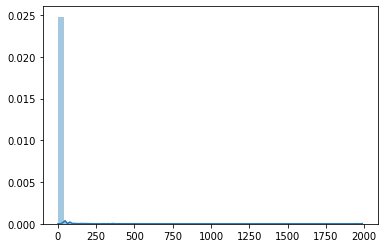

In [83]:
sns.distplot(list(co.values()))